In [1]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import copy

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [3]:
import pandas as pd
data = pd.read_csv("omnipath.csv")

data = data.iloc[:, [1, 2, 3]]

from sklearn.preprocessing import LabelEncoder

node_encoder = LabelEncoder()

nodes = pd.concat([data['from'], data['to']]).unique()
node_encoder.fit(nodes)

data['from_encoded'] = node_encoder.transform(data['from'])
data['to_encoded'] = node_encoder.transform(data['to'])

In [4]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

<ipython-input-4-42ec696188e5>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)


In [5]:
data_py = train_test_split_edges(data_py)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Setting up Graph Variational Autoencoder:

In [6]:
from torch_geometric.nn import VGAE

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)
        #The sd is typically expressed in terms of its logarithm, to ensure numerical stability and easier optimization.

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [7]:
out_channels = 16
num_features = data_py.x.shape[1]
epochs = 500

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
def val(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def test(model_best,pos_edge_index, neg_edge_index):
    model_best.eval()
    with torch.no_grad():
        z = model_best.encode(x, train_pos_edge_index)
        pos_prob = model_best.decode(z, pos_edge_index)
        neg_prob = model_best.decode(z, neg_edge_index)

    return pos_prob, neg_prob

In [11]:
def train_2():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss = loss + (1 / data_py.num_nodes) * model.kl_loss()  # + kl divergence
    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [12]:
best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(1, epochs + 1):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 001, Loss: 3.5875, Val AUC: 0.8906, Val AP: 0.8942
Epoch: 002, Loss: 3.0759, Val AUC: 0.8949, Val AP: 0.8959
Epoch: 003, Loss: 2.4030, Val AUC: 0.8947, Val AP: 0.8947
Epoch: 004, Loss: 2.0535, Val AUC: 0.8977, Val AP: 0.8990
Epoch: 005, Loss: 1.9021, Val AUC: 0.9022, Val AP: 0.9044
Epoch: 006, Loss: 1.7979, Val AUC: 0.9043, Val AP: 0.9067
Epoch: 007, Loss: 1.6553, Val AUC: 0.9029, Val AP: 0.9045
Epoch: 008, Loss: 1.5095, Val AUC: 0.9013, Val AP: 0.9014
Epoch: 009, Loss: 1.3997, Val AUC: 0.8957, Val AP: 0.8940
Epoch: 010, Loss: 1.3666, Val AUC: 0.8879, Val AP: 0.8854
Epoch: 011, Loss: 1.3445, Val AUC: 0.8834, Val AP: 0.8816
Epoch: 012, Loss: 1.3198, Val AUC: 0.8835, Val AP: 0.8829
Epoch: 013, Loss: 1.3116, Val AUC: 0.8862, Val AP: 0.8865
Epoch: 014, Loss: 1.2995, Val AUC: 0.8913, Val AP: 0.8922
Epoch: 015, Loss: 1.2728, Val AUC: 0.8986, Val AP: 0.9001
Epoch: 016, Loss: 1.2490, Val AUC: 0.9051, Val AP: 0.9068
Epoch: 017, Loss: 1.2275, Val AUC: 0.9082, Val AP: 0.9096
Epoch: 018, Lo

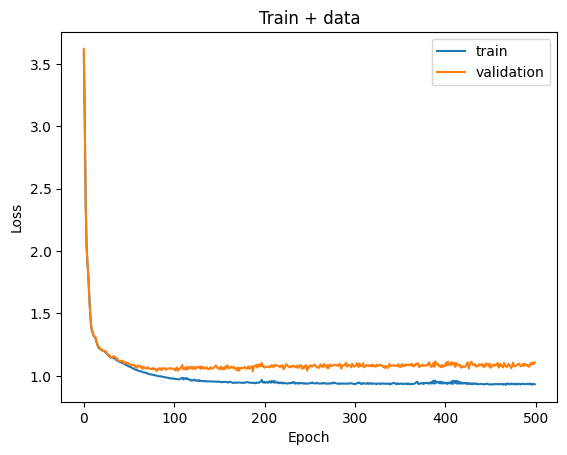

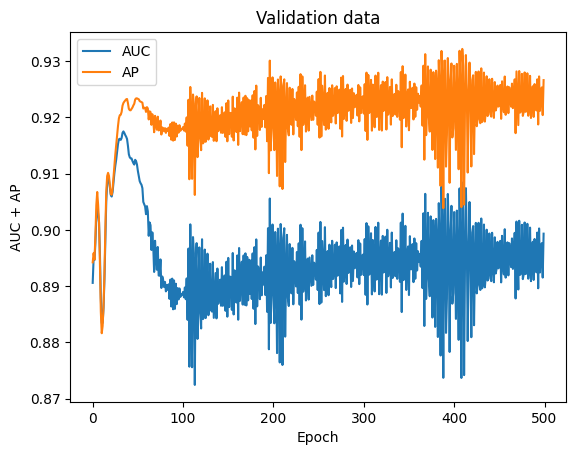

In [13]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [16]:
model_1 = best_model
pos_1, neg_1 = test(model_1,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [17]:
percentage = ((pos_1 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

63.03% links predicted correctly


Setting up Bayesian Optimization for VGAE

In [ ]:
import optuna
from tqdm import tqdm

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(VariationalGCNEncoder, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(in_channels, 2 * out_channels, cached=True))

        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(2 * out_channels, 2 * out_channels, cached=True))

        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


def objective(trial):
    # Define hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of GCN layers
    out_channels = trial.suggest_int('out_channels', 8, 64)  # Latent dimension
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate
    node_feature_dim = trial.suggest_categorical('node_feature_dim', [16, 32, 64, 128]) #node feature dimension

    num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1
    node_features = torch.rand((num_nodes, node_feature_dim), dtype=torch.float)

    # PyG Data object
    data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    data_py = train_test_split_edges(data_py)

    # model
    model = VGAE(VariationalGCNEncoder(node_feature_dim, out_channels, num_layers)).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = 0


    for epoch in tqdm(range(300), desc=f"Trial {trial.number + 1} Progress", leave=False):
            loss, loss2 = train_2()

            # Evaluate on validation set
            val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)

            if val_auc > best_val_auc:
              best_val_auc = val_auc


    return best_val_auc  # Objective to maximize


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best value
print("Best hyperparameters:", study.best_params)
print("Best validation AUC:", study.best_value)

Best hyperparameters: {'num_layers': 3, 'out_channels': 42, 'lr': 0.009936477241185999, 'node_feature_dim': 32}

Best validation AUC: 0.9192401871035691


Testing the best parameters found:

In [18]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()

        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 000, Loss: 5.6345, Val AUC: 0.9130, Val AP: 0.9153
Epoch: 001, Loss: 4.1115, Val AUC: 0.9091, Val AP: 0.9122
Epoch: 002, Loss: 3.1194, Val AUC: 0.9010, Val AP: 0.9045
Epoch: 003, Loss: 2.4464, Val AUC: 0.9028, Val AP: 0.9054
Epoch: 004, Loss: 1.7760, Val AUC: 0.9141, Val AP: 0.9163
Epoch: 005, Loss: 1.4828, Val AUC: 0.9118, Val AP: 0.9143
Epoch: 006, Loss: 1.3736, Val AUC: 0.9043, Val AP: 0.9080
Epoch: 007, Loss: 1.2939, Val AUC: 0.9035, Val AP: 0.9075
Epoch: 008, Loss: 1.3455, Val AUC: 0.9055, Val AP: 0.9082
Epoch: 009, Loss: 1.2217, Val AUC: 0.9089, Val AP: 0.9121
Epoch: 010, Loss: 1.3185, Val AUC: 0.9051, Val AP: 0.9072
Epoch: 011, Loss: 1.2182, Val AUC: 0.9045, Val AP: 0.9076
Epoch: 012, Loss: 1.2815, Val AUC: 0.9079, Val AP: 0.9097
Epoch: 013, Loss: 1.2117, Val AUC: 0.9088, Val AP: 0.9113
Epoch: 014, Loss: 1.3519, Val AUC: 0.9015, Val AP: 0.9044
Epoch: 015, Loss: 1.2302, Val AUC: 0.9030, Val AP: 0.9064
Epoch: 016, Loss: 1.4376, Val AUC: 0.9039, Val AP: 0.9062
Epoch: 017, Lo

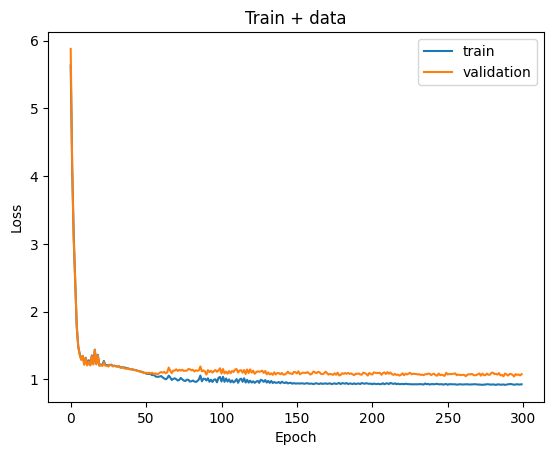

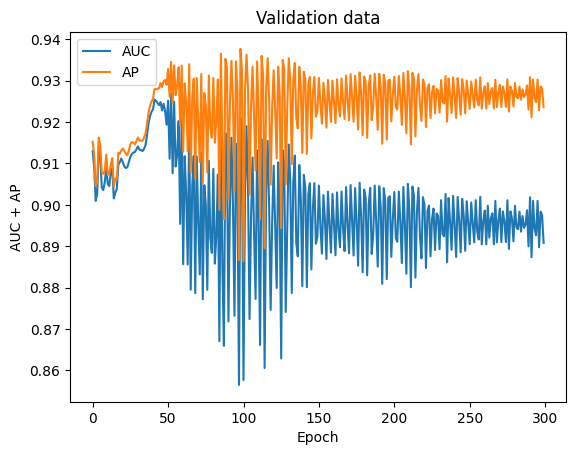

In [19]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [20]:
model_2 = best_model
pos_2, neg_2 = test(model_2,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [31]:
percentage = ((pos_2 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

81.24% links predicted correctly


Now we shall add further tune this architecture by experimenting with dropout, batch normalization etc.

In [38]:
def train_3():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    recon_loss = model.recon_loss(z, train_pos_edge_index)

    kl_loss = (1 / data_py.num_nodes) * model.kl_loss()


    # L2 regularization
    l2_lambda = 1e-5
    l2_reg = sum(torch.sum(param ** 2) for param in model.parameters())

    # Total loss
    loss = recon_loss + kl_loss + l2_lambda * l2_reg

    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [39]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()


        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.bn1 = torch.nn.BatchNorm1d(2 * out_channels) #batch normalization

        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.bn2 = torch.nn.BatchNorm1d(2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

        self.dropout = torch.nn.Dropout(p=0.5)


        self.act = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 000, Loss: 27.1204, Val AUC: 0.8960, Val AP: 0.9006
Epoch: 001, Loss: 15.4021, Val AUC: 0.9002, Val AP: 0.9043
Epoch: 002, Loss: 9.4839, Val AUC: 0.9048, Val AP: 0.9079
Epoch: 003, Loss: 6.6287, Val AUC: 0.9097, Val AP: 0.9117
Epoch: 004, Loss: 4.8358, Val AUC: 0.9118, Val AP: 0.9129
Epoch: 005, Loss: 4.1586, Val AUC: 0.9124, Val AP: 0.9128
Epoch: 006, Loss: 3.9362, Val AUC: 0.9129, Val AP: 0.9131
Epoch: 007, Loss: 3.7488, Val AUC: 0.9139, Val AP: 0.9146
Epoch: 008, Loss: 3.3506, Val AUC: 0.9165, Val AP: 0.9181
Epoch: 009, Loss: 2.9032, Val AUC: 0.9196, Val AP: 0.9219
Epoch: 010, Loss: 2.6363, Val AUC: 0.9202, Val AP: 0.9232
Epoch: 011, Loss: 2.4088, Val AUC: 0.9196, Val AP: 0.9234
Epoch: 012, Loss: 2.3973, Val AUC: 0.9186, Val AP: 0.9231
Epoch: 013, Loss: 2.2891, Val AUC: 0.9179, Val AP: 0.9231
Epoch: 014, Loss: 2.1897, Val AUC: 0.9172, Val AP: 0.9227
Epoch: 015, Loss: 2.0862, Val AUC: 0.9184, Val AP: 0.9240
Epoch: 016, Loss: 1.9966, Val AUC: 0.9215, Val AP: 0.9270
Epoch: 017, 

In [40]:
model_3 = best_model
pos_3, neg_3 = test(model_3,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [48]:
percentage = ((pos_3 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

94.11% links predicted correctly


In [49]:
(neg_2 >= 0.99).sum()

tensor(6)

For a threshold of 0.7

Batch + dropout and with L-2 regularizatrion: 94.11

Batch + dropout and without L-2 regularizatrion: 91.09



# **Further Analysis of the best model architecture found**

---


**How many links were not predicted and which of these links had the lowest probabilities of existence?**

In [50]:
(pos_3 < 0.7).sum() # how many links were not predicted with the threshold of 0.7

tensor(257)

In [51]:
sorted_probabilities = pos_3.sort()

lowest_probabilities = sorted_probabilities.values
lowest_indices = sorted_probabilities.indices

num_lowest = 10
lowest_10_values = lowest_probabilities[:num_lowest]
lowest_10_indices = lowest_indices[:num_lowest]

print(f"10 lowest probabilities: {lowest_10_values}")

10 lowest probabilities: tensor([0.0102, 0.3431, 0.3538, 0.3688, 0.3778, 0.3875, 0.3910, 0.3944, 0.4064,
        0.4200])


In [52]:
from_node = data_py.test_pos_edge_index.cpu()[0][lowest_10_indices.cpu()]
to_node = data_py.test_pos_edge_index.cpu()[1][lowest_10_indices.cpu()]

print("from:",from_node)
print("to:",to_node)

from: tensor([5397, 1469, 2508, 6605, 2734, 2497, 1988, 2190, 2523, 5397])
to: tensor([7137, 3940, 2610, 7977, 8694, 2501, 4930, 7542, 6363, 5868])


**links with the lowest probabilities of existence?**

In [53]:
from_node_name = node_encoder.inverse_transform(from_node)
to_node_name = node_encoder.inverse_transform(to_node)

for from_name, to_name in zip(from_node_name, to_node_name):
    print(f"({from_name}, {to_name})")

(MYC, RBM14)
(CEBPB, HSD17B7)
(EFEMP2, ELN)
(PPARA, SLC22A3)
(ESR1, TEX11)
(EEF1B2, EEF1G)
(CUL3, MAP1S)
(DEPDC5:NPRL2:NPRL3, RRAGA)
(EGFR, PIK3C2B)
(MYC, NTMT1)


**new links that had the highest probabilities of existence?**

In [54]:
desc_sorted_probabilities = neg_3.sort(descending=True)

highest_probabilities = desc_sorted_probabilities.values
highest_indices = desc_sorted_probabilities.indices

num_highest = 10
highest_10_values = highest_probabilities[:num_highest]
highest_10_indices = highest_indices[:num_highest]

print(f"10 lowest probabilities: {highest_10_values}")

10 lowest probabilities: tensor([1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9998, 0.9996, 0.9993, 0.9993,
        0.9990])


In [55]:
from_node_2 = data_py.test_neg_edge_index.cpu()[0][highest_10_indices.cpu()]
to_node_2 = data_py.test_neg_edge_index.cpu()[1][highest_10_indices.cpu()]

print("from:",from_node_2)
print("to:",to_node_2)

from: tensor([5397,  893,  502, 2746, 9434,  304, 1952,  893, 3771, 2581])
to: tensor([6678, 8367, 2753, 3234, 9879, 7783, 5700, 4833, 6405, 3060])


In [56]:
from_node_name = node_encoder.inverse_transform(from_node_2)
to_node_name = node_encoder.inverse_transform(to_node_2)

for from_name, to_name in zip(from_node_name, to_node_name):
    print(f"({from_name}, {to_name})")

(MYC, PPP3CA)
(BIRC6:UBB, SST)
(AR, ETV7)
(ETS2, GATA1)
(UNKL, ZNRF4)
(AKT1, SERPINE1)
(CTNNB1, NLRP2)
(BIRC6:UBB, LRRCC1)
(HIF1A, PJA2)
(EIF4ENIF1, FOSL2:JUN)


In [59]:
data[(data['from'] == "CEBPB")]

,from,to,sign,from_encoded,to_encoded
7614,CEBPB,A2M,1,1469,2
7615,CEBPB,ABCB1,1,1469,20
7616,CEBPB,ABCC3,1,1469,29
7617,CEBPB,ABCC8,1,1469,33
7618,CEBPB,ACACA,1,1469,60
...,...,...,...,...,...
8002,CEBPB,XBP1,1,1469,9638
8003,CEBPB,XDH,1,1469,9642
8004,CEBPB,XIAP,1,1469,9643
8005,CEBPB,YWHAE,1,1469,9682


In [64]:
data[(data['from'] == "MYC") & (data['to'] == "PPP3CA")]

,from,to,sign,from_encoded,to_encoded
